# Predicting Amazon review score based only on the text

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import math
#from bson import ObjectId
from pymongo import MongoClient

import re
#import os

#import json

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

client = MongoClient()


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ordovas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Now we load a fraction of the dataset.

In [2]:
db = client.get_database("amazon")
# Define an alias for the books dataset
books =db.books
# Obtain a random sample from the dataset
res = list(books.aggregate([
    { "$sample": { "size": 60000 } }
]))
# Converting to pandas DataFrame
df=pd.DataFrame(res)

In [3]:
df.head()

,_id,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,6033ab88f7ccad4a92f619df,3,True,"02 10, 2013",AM1LAWCJEM03D,0007436580,{'Format:': ' Kindle Edition'},Pat Arnold,IT WAS OKAY. I WAS GLAD I DIDNT PAY A LOT FO...,CRYING FOR HELP,1360454400,NaN,NaN
1,6033ab99f7ccad4a92f95bf9,4,True,"11 17, 2016",A2NJ14VHS1KCP5,0060092955,{'Format:': ' Paperback'},nowintexas,I purchased this book after my son became obse...,Cute book but not superb,1479340800,NaN,NaN
2,6033ab72f7ccad4a92f1be11,4,True,"07 14, 2015",ANL2PGW1NUV0I,0002226529,NaN,Corinnepea,Love Mary Higgins Clark,Four Stars,1436832000,NaN,NaN
3,6033ab9bf7ccad4a92f9d10c,4,False,"09 11, 2002",A3T7MC28NFTYCH,0060161183,{'Format:': ' Paperback'},Randall Ivey,Hillerman has carved out his own niche in the ...,Don't Start Here (If You've Never Read Hillerm...,1031702400,29,NaN
4,6033ab82f7ccad4a92f4c357,4,True,"04 19, 2015",A2ZN6C51PHTKA6,0007350783,{'Format:': ' Kindle Edition'},Lady Silverlocks,I enjoyed this modern version of Emma. I haven...,I enjoyed this modern version of Emma,1429401600,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   _id             60000 non-null  object
 1   overall         60000 non-null  int64 
 2   verified        60000 non-null  bool  
 3   reviewTime      60000 non-null  object
 4   reviewerID      60000 non-null  object
 5   asin            60000 non-null  object
 6   style           57198 non-null  object
 7   reviewerName    59998 non-null  object
 8   reviewText      59989 non-null  object
 9   summary         59990 non-null  object
 10  unixReviewTime  60000 non-null  int64 
 11  vote            11304 non-null  object
 12  image           82 non-null     object
dtypes: bool(1), int64(2), object(10)
memory usage: 5.6+ MB


In [5]:
df=df.dropna(subset=['reviewText', 'reviewerName',"summary"])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59977 entries, 0 to 59999
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   _id             59977 non-null  object
 1   overall         59977 non-null  int64 
 2   verified        59977 non-null  bool  
 3   reviewTime      59977 non-null  object
 4   reviewerID      59977 non-null  object
 5   asin            59977 non-null  object
 6   style           57176 non-null  object
 7   reviewerName    59977 non-null  object
 8   reviewText      59977 non-null  object
 9   summary         59977 non-null  object
 10  unixReviewTime  59977 non-null  int64 
 11  vote            11302 non-null  object
 12  image           81 non-null     object
dtypes: bool(1), int64(2), object(10)
memory usage: 6.0+ MB


In [7]:
df["vote"]=df["vote"].fillna(value=0)
df["vote"]=df["vote"].apply(lambda x: int(str(x).replace(",","")))


In [8]:
df["overall"].value_counts()

5    37876
4    12222
3     5340
2     2415
1     2124
Name: overall, dtype: int64

In [9]:
def cleaning_review(texts):
    #Remove numbers, punctuation and lowercase everything
    res=re.sub("[^A-Za-z]+", " ", texts.lower()) 
    #Remove words with less than 4 letters
    res=re.sub(r'\b\w{1,3}\b', "", res) 
    #Remove rest of stop words
    for stopword in stopwords.words('english'): 
        sw=stopword.replace("'","")
        res=res.replace(f" {sw} "," ")
    return res

df["review_clean"]=df["reviewText"]
df["review_clean"]=df["review_clean"].apply(cleaning_review)

In [10]:

df=df.reset_index()


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer(min_df=5)
x = v.fit_transform(df['review_clean']).toarray()

In [12]:
df_tfidf = pd.DataFrame(x, columns=v.get_feature_names())

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df_tfidf, df["overall"], test_size=0.15, random_state=42)

In [14]:
len(y_train),len(y_test)

(50980, 8997)

In [15]:
len(df_tfidf.columns)

22539

In [16]:
clf = LogisticRegression(random_state=0,class_weight="balanced").fit(X_train, y_train)


/home/ordovas/anaconda3/envs/ironhack/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
y_pred=clf.predict(X_train)

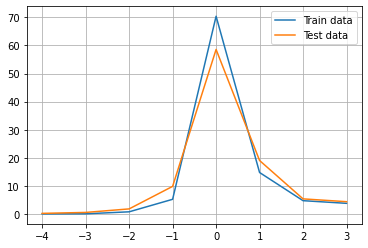

In [18]:
counts, bins = np.histogram(y_train-clf.predict(X_train),bins=np.arange(-4,5))
plt.plot(bins[:-1],counts*100/sum(counts),label="Train data")
plt.grid()
counts, bins = np.histogram(y_test-clf.predict(X_test),bins=np.arange(-4,5))
plt.plot(bins[:-1],counts*100/sum(counts),label="Test data")
plt.legend();

In [19]:
clf.score(X_train, y_train)

0.7038054138877992

In [20]:
clf.score(X_test, y_test)

0.5856396576636657

In [21]:
confusion_matrix(y_train,clf.predict(X_train))

array([[ 1668,    58,    22,    15,    31],
       [   78,  1878,    70,    36,    36],
       [  207,   328,  3259,   440,   354],
       [  291,   438,  1332,  6239,  2113],
       [  873,   788,  1787,  5803, 22836]])

In [22]:
confusion_matrix(y_test,clf.predict(X_test))

array([[ 167,   76,   38,   26,   23],
       [  80,  112,   71,   27,   27],
       [  75,  134,  262,  180,  101],
       [  66,   90,  318,  775,  560],
       [ 171,  160,  322, 1183, 3953]])

In [23]:
clf.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

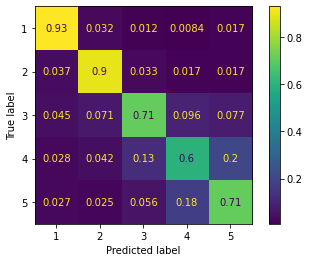

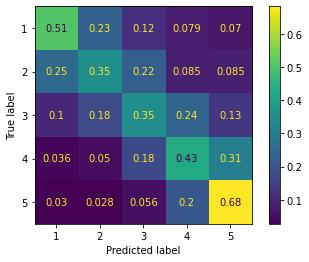

In [24]:
plot_confusion_matrix(clf, X_train, y_train,cmap="viridis",normalize="true") 
plot_confusion_matrix(clf, X_test, y_test,cmap="viridis",normalize="true")
plt.show();

In [25]:
model=pd.DataFrame(clf.coef_,columns=X_train.columns)
model=model.T
model.columns=["1","2","3","4","5"]

In [26]:
model["5"].sort_values(ascending=False).head(20)

highly         4.484097
excellent      4.045599
great          3.890946
wonderful      3.780433
amazing        3.629508
love           3.490875
perfect        3.456370
fantastic      3.309573
loved          3.117156
awesome        3.047435
beautiful      2.958332
brilliant      2.842893
thank          2.798243
beautifully    2.702918
loves          2.561907
wait           2.557949
incredible     2.415949
keeps          2.332581
wonderfully    2.314362
masterpiece    2.294892
Name: 5, dtype: float64

In [27]:
model["1"].sort_values(ascending=False).head(20)

waste         6.505779
worst         4.742713
terrible      4.582867
awful         4.055568
trash         3.779797
money         3.661456
boring        3.632212
horrible      3.625463
even          3.512811
wasted        3.429691
bother        3.323911
garbage       3.320470
rubbish       3.314021
stupid        3.304465
ridiculous    3.282121
terribly      3.251973
refund        3.171680
poorly        3.124993
lame          3.123927
returned      3.079353
Name: 1, dtype: float64

In [28]:
model["3"].sort_values(ascending=False).head(20)

okay             3.527615
however          2.963216
mediocre         2.787796
seemed           2.475055
still            2.421945
somewhat         2.419723
lacking          2.240698
alright          2.233896
felt             2.220561
though           2.219002
average          2.123789
unfortunately    2.099501
result           2.076707
kinda            2.048846
similar          2.046262
standards        2.033071
kind             2.029766
tends            1.941339
teens            1.919732
decent           1.919678
Name: 3, dtype: float64

In [29]:
model["5"].sort_values(ascending=True).head(20)

disappointing    -4.194741
boring           -4.172399
instead          -3.525276
however          -3.418187
unfortunately    -3.312846
worst            -3.255500
slow             -3.237849
tedious          -3.198042
depressing       -3.123319
waste            -3.081229
seemed           -3.050590
okay             -2.819607
predictable      -2.785566
problem          -2.763692
disappointment   -2.718056
seems            -2.687579
ridiculous       -2.682807
maybe            -2.554073
annoying         -2.521151
nothing          -2.495095
Name: 5, dtype: float64

In [30]:
model["1"].sort_values(ascending=True).head(20)

excellent     -3.965991
great         -3.885040
well          -3.488946
stars         -3.384476
best          -3.384062
though        -3.343120
fascinating   -3.322394
enjoyed       -3.147007
usual         -3.103360
perfect       -3.100816
easy          -3.060450
turner        -2.951096
fairly        -2.826704
almost        -2.684947
eyes          -2.654855
rachel        -2.654685
amazing       -2.620896
interesting   -2.578624
love          -2.555968
highly        -2.534511
Name: 1, dtype: float64

In [31]:
model["3"].sort_values(ascending=True).head(20)

even         -3.278575
wasted       -2.345926
highly       -2.131530
wonderful    -2.054196
absolutely   -1.980176
adventure    -1.923176
recommend    -1.922932
large        -1.914421
complaint    -1.907569
ever         -1.899230
wait         -1.888203
amazon       -1.834478
loving       -1.820636
deeply       -1.813664
brings       -1.810703
important    -1.753685
children     -1.750991
extra        -1.737914
quit         -1.734294
couldn       -1.660330
Name: 3, dtype: float64